In [1]:
import torch
from torch import nn

In [2]:
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/carvana-image-masking-png/train_images/"
TRAIN_DIR_MASK = "/kaggle/input/carvana-image-masking-png/train_masks/"
BATCH_SIZE = 4
LEARNING_RATE = 3e-4
NUM_WORKERS = 2
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_UNET = "unet.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        ToTensorV2(),
    ]
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class CityDataset(Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.list_file = os.listdir(self.root_dir)

        
    def __len__(self):
        return len(self.list_file)
    

    def __getitem__(self, index):
        img_file = self.list_file[index]
        img_path = os.path.join(self.root_dir, img_file)
        mask_path = os.path.join(self.mask_dir, img_file)
        input_img = np.array(Image.open(img_path))
        target_img = np.array(Image.open(mask_path[:-3] + "png"))
        
        augmentations = both_transform(image=input_img, image0=target_img)
        input_img, target_img = augmentations['image'], augmentations['image0']
        
        input_img = transform_only_input(image=input_img)['image']
        target_img = transform_only_mask(image=target_img)['image']
        
        return input_img, target_img

(tensor([  0., 255.]), tensor([53444, 12092]))


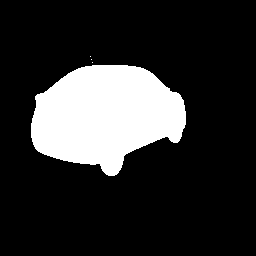

In [4]:
from torch.utils.data import DataLoader
te_dataset = CityDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
te_loader = DataLoader(te_dataset, batch_size=1, shuffle=True, num_workers=1)

batch= iter(te_loader)
images, labels = next(batch)
import torchvision.transforms as T
labels[0].shape
print(torch.unique(labels[0].float() * 255, return_counts=True))
transform = T.ToPILImage()
transform(labels[0].float())

In [8]:
import torch
from torchvision.utils import save_image

def save_some_examples(unet, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    unet.eval()
    with torch.no_grad():
        y_fake = unet(x)
        y_fake = y_fake  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(y.float() , folder + f"/label_{epoch}.png")
    unet.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load("/kaggle/input/models/" + checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [2]:
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
    
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        
        #Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(2 * feature, feature, 2, 2))
            self.ups.append(DoubleConv(feature * 2, feature))
            in_channels = feature
            
        self.final = nn.Conv2d(features[0], out_channels, 1)
        
    def forward(self, x):
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skips = skips[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skips[idx//2]
            
            if skip.shape != x.shape:
                x = TF.resize(x, size=(skip.shape[2:]))
            x = self.ups[idx + 1](torch.cat([x, skip], dim=1))
            
        return self.final(x)
    
x = torch.randn(5, 3, 160, 160)
unet = UNET()
y = unet(x)
print(y.shape)
sum(p.numel() for p in unet.parameters() if p.requires_grad)

torch.Size([5, 1, 160, 160])


31037633

In [6]:
unet

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
print(SAVE_MODEL)
torch.backends.cudnn.benchmark = True

def train_fn(unet, train_loader, opt, loss_fn, scaler):
    loop = tqdm(train_loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.float().to(DEVICE)
        
        #Train Discriminator
        with torch.cuda.amp.autocast():
            segment = unet(x)
            loss = loss_fn(segment, y)
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loop.set_postfix(loss=loss.item())

        
        
def main():
    unet = UNET(in_channels=3).to(DEVICE)
    opt=optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    
    loss = nn.BCEWithLogitsLoss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_UNET, unet, opt, LEARNING_RATE)
        
    train_dataset = CityDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(1))
    scaler = torch.cuda.amp.GradScaler()
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    for epoch in range(NUM_EPOCHS):
        train_fn(unet, train_loader, opt, loss, scaler)
        
        if(SAVE_MODEL and epoch % 5 == 0):
            save_checkpoint(unet, opt, filename=CHECKPOINT_UNET)
        if epoch % 5 == 0:
            save_some_examples(unet, val_loader, epoch, folder='.')

main()

True


100%|██████████| 1018/1018 [02:24<00:00,  7.05it/s, loss=0.0543]


=> Saving checkpoint


100%|██████████| 1018/1018 [02:23<00:00,  7.09it/s, loss=0.0622]


=> Saving checkpoint


100%|██████████| 1018/1018 [02:26<00:00,  6.95it/s, loss=0.0477]


=> Saving checkpoint


100%|██████████| 1018/1018 [02:25<00:00,  7.02it/s, loss=0.0435] 


=> Saving checkpoint


100%|██████████| 1018/1018 [02:24<00:00,  7.06it/s, loss=0.034]  


=> Saving checkpoint


100%|██████████| 1018/1018 [02:24<00:00,  7.02it/s, loss=0.00599]


=> Saving checkpoint


 24%|██▍       | 244/1018 [00:35<01:51,  6.97it/s, loss=0.0316] 


KeyboardInterrupt: 